In [28]:
from collections import defaultdict
from run import ScriptArguments, get_pz_list
from datasets import fingerprint
from transformers import HfArgumentParser, set_seed
import torch
from typing import cast
from datasets.utils._dill import dumps
import os

def pull_data(seed_list, max_xw_list, model_name_list, num_test_examples_list):
    num_test_examples_list = sorted(num_test_examples_list, reverse=True)
    
    configs = {}
    results = defaultdict(list)
    for seed in seed_list:
        for max_xw in max_xw_list:
            for model_name in model_name_list:
                # find the result with the biggest number of test examples
                for num_test_examples in num_test_examples_list:
                    config = ScriptArguments(
                        debug=False,
                        api='togetherai',
                        seed=seed,
                        model_name=model_name,
                        max_w=max_xw,
                        max_x=max_xw,
                        pz_end=600,
                        pz_start=2,
                        pz_dist='log',
                        pz_count=100,
                        num_test_examples=num_test_examples,
                        device='cuda:1'
                    )
                    set_seed(seed)
                    fp_old = fingerprint.Hasher().hash(config.__dict__)
                    fp = repr(config)
                    # print(fp)
                    folder = f'{config.out_dir}/cache/{fp}/'
                    if os.path.exists(folder):
                        break
                    folder = f'{config.out_dir}/cache/{fp_old}/'
                    if os.path.exists(folder):
                        # migrate to new fp
                        os.rename(folder, f'{config.out_dir}/cache/{fp}/')
                        break
                all_answers = torch.load(f'{config.out_dir}/cache/{fp}/answers.pt')
                all_targets = torch.load(f'{config.out_dir}/cache/{fp}/targets.pt')
                mse = (all_answers - all_targets).float().pow(2) # (num_test_examples, len(pz_list))
                mse_pad = torch.cat([mse, torch.nan * torch.ones(num_test_examples_list[0] - mse.shape[0], mse.shape[1])])
                results[(max_xw, model_name)].append(mse_pad)
                configs[(max_xw, model_name)] = config

    results = {k: torch.stack(results[k]) for k in results}
    return results, configs


In [8]:
list(results.values())[0].shape # (num_seeds, num_test_examples, len(pz_list))

torch.Size([100, 1, 77])

In [77]:
from matplotlib import pyplot as plt
from random import choices

def plot_2x2_avg(results, configs, x_list, w_list):
    def remove_outliers(data, labels):
        return data[data <= 1], labels[data <= 1]

    fig = plt.figure(figsize=(13, 10))
    axs = fig.subplots(2, 2)
    for col, avg_over_w in enumerate(w_list):
        for row, avg_over_x in enumerate(x_list):
            for k in results:
                res_mask = (~results[k].isnan()).prod(dim=-1)
                # print(res_mask)
                avail_w = torch.count_nonzero(res_mask, dim=0) >= avg_over_w
                avail_x = torch.count_nonzero(res_mask, dim=1) >= avg_over_x
                avail = torch.outer(avail_x, avail_w)
                # print(avail)
                i, j = torch.nonzero(avail, as_tuple=True)
                if len(i) < avg_over_w or len(j) < avg_over_x:
                    print(f'Not enough data for {k[1].split("/")[1]} {k[0]}')
                    continue
                i, j = choices(i, k=avg_over_w), choices(j, k=avg_over_x)
                # print(i, j)
                dat = results[k][i, :, :][:, j, :]
                # print(dat.shape)
                dat = dat.mean(dim=1).sqrt().mean(dim=0) / (configs[k].max_w * configs[k].max_x)
                # print(dat.shape)
                labels = torch.tensor(get_pz_list(configs[k]))
                dat, labels = remove_outliers(dat, labels)
                axs[row][col].plot(labels, dat, label=f'{k[1].split("/")[1]} {k[0]}')
            axs[row][col].set_xlabel('Prompt size')
            axs[row][col].set_ylabel('RMSE')
            axs[row][col].semilogy()
            axs[row][col].legend()
            axs[row][col].set_title(f'Prompt size vs RMSE, average over {avg_over_w} weights, {avg_over_x} examples')

    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
Not enough data for Meta-Llama-3-8B 1000


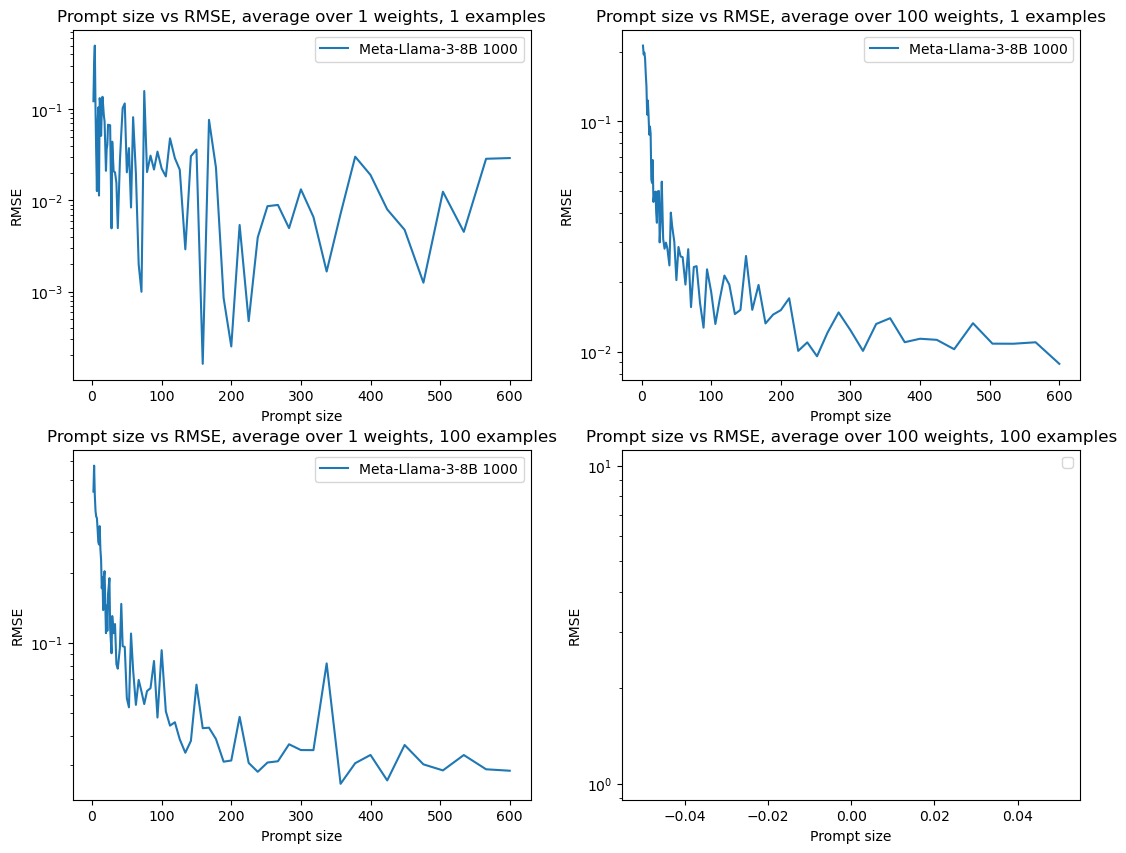

In [78]:
results, configs = pull_data(seed_list=range(100), max_xw_list=[1000], model_name_list=['meta-llama/Meta-Llama-3-8B'], num_test_examples_list=[100, 1])
plot_2x2_avg(results, configs, x_list=[1, 100], w_list=[1, 100])


In [56]:
    # for model_name in ['meta-llama/Meta-Llama-3-8B', 'meta-llama/Meta-Llama-3-70B']:
    #     pz_end = 600
    #     pz_count = 50
    #     pz_dist = 'log'
    #     num_test_examples = 10
    # for model_name in ['Qwen/Qwen1.5-32B']:
    #     pz_end = 1000
        # pz_count = 50
    #     pz_dist = 'log'
        # num_test_examples = 10